0 have 20 slice left
already use 0.019 min
-----------
expanding...
success expand
1 have 16 slice left
already use 0.039 min
-----------
2 have 17 slice left
already use 0.058 min
-----------
3 have 40 slice left
already use 0.083 min
-----------
4 have 28 slice left
already use 0.102 min
-----------
5 have 36 slice left
already use 0.124 min
-----------
6 have 35 slice left
already use 0.141 min
-----------
7 have 16 slice left
already use 0.159 min
-----------
expanding...
success expand
8 have 16 slice left
already use 0.180 min
-----------
expanding...
success expand
9 have 16 slice left
already use 0.199 min
-----------
10 have 35 slice left
already use 0.216 min
-----------
11 have 35 slice left
already use 0.236 min
-----------
12 have 23 slice left
already use 0.256 min
-----------
13 have 27 slice left
already use 0.276 min
-----------
14 have 29 slice left
already use 0.297 min
-----------
15 have 25 slice left
already use 0.316 min
-----------
16 have 17 slice left
already 

139 have 26 slice left
already use 2.848 min
-----------
140 have 24 slice left
already use 2.867 min
-----------
141 have 17 slice left
already use 2.885 min
-----------
142 have 22 slice left
already use 2.906 min
-----------
143 have 20 slice left
already use 2.924 min
-----------
144 have 31 slice left
already use 2.941 min
-----------
145 have 19 slice left
already use 2.958 min
-----------
146 have 41 slice left
already use 2.979 min
-----------
147 have 29 slice left
already use 3.001 min
-----------
148 have 43 slice left
already use 3.022 min
-----------
149 have 28 slice left
already use 3.047 min
-----------


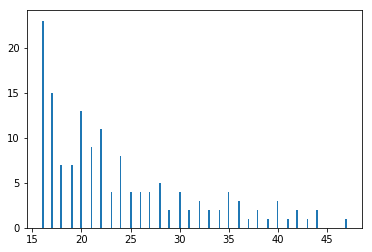

In [55]:
"""

获取固定取样方式下的训练数据

首先将灰度值超过upper和低于lower的灰度进行截断
然后将slice的分辨率调整为256*256

只有包含肝脏病变以及肝脏病变上下 expand_slice 张slice作为训练样本
对每个病人按其expand_slice以16，32，48三个阈值对图像进行了分块
将每个病人都分成了包含16个切片的nii图像（原小于等于16的现在只有一个nii,17-32的有两个nii,33-48的有三个nii）
网络输入为256*256*size

"""

import os
import shutil
from time import time

import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage

upper = 200
lower = -200
expand_slice = 6  # 轴向上向外扩张的slice数量
size = 16  # 取样的slice数量
# stride = 1  # 取样的步长
down_scale = 0.5
slice_thickness = 5


# 用来统计最终剩下的slice数量
left_slice_list = []

start_time = time()
# for ct_file in os.listdir(ct_dir):
for i in range(150):

    # 将CT和金标准入读内存
    ct = sitk.ReadImage('/home/yanxin/data_ct/'+str(i) + 'Venous_tra_5mm.nii', sitk.sitkInt16)
    ct_array = sitk.GetArrayFromImage(ct)

    seg = sitk.ReadImage('/home/yanxin/data_ct/'+str(i) + 'Venous_tra_5mm_roi.nii', sitk.sitkInt16)
    seg_array = sitk.GetArrayFromImage(seg)

    seg_array[seg_array > 0] = 1

    # 将灰度值在阈值之外的截断掉 
    ct_array[ct_array > upper] = upper
    ct_array[ct_array < lower] = lower

    # 对CT和金标准进行插值，插值之后的array依然是int类型
    # order=3 cubic interpolation:'   1, 0.5 0.5  三次样条插值 0.5的话是下采样了 变成256*256
    ct_array = ndimage.zoom(ct_array, (ct.GetSpacing()[-1] / slice_thickness, down_scale, down_scale), order=3)

    # order=0 nearest interpolation:  1,1,1  不变
    seg_array = ndimage.zoom(seg_array, (ct.GetSpacing()[-1] / slice_thickness,  1, 1), order=0)#也缩小一下吧，看看是否对应

    # 找到肝脏区域开始和结束的slice，并各向外扩张
    z = np.any(seg_array, axis=(1, 2))
    start_slice, end_slice = np.where(z)[0][[0, -1]]  # 就是包含病变的

    # 两个方向上各扩张个slice，一个方向就扩目前先设置为6
    if start_slice - expand_slice < 0:
        start_slice = 0
    else:
        start_slice -= expand_slice

    if end_slice + expand_slice >= seg_array.shape[0]:
        end_slice = seg_array.shape[0] - 1
    else:
        end_slice += expand_slice


    if end_slice - start_slice + 1 < size:  # 第一种情况，如果小于16了，要扩容
        print('expanding...')
        diff = size - (end_slice - start_slice + 1)
#         print('diff',diff)
        left_right_expand=[(m,diff-m) for m in range(diff+1)]

        for left_right in left_right_expand:
            end_slice_now =end_slice+ left_right[1]
            start_slice_now =start_slice- left_right[0]
#         else:
#             end_slice = end_slice + 1 + expand_value
#             start_slice -= expand_value
            if start_slice_now >= 0 and end_slice_now <= ct_array.shape[0] - 1:
                print('success expand')
                end_slice =end_slice_now
                start_slice =start_slice_now
                break

    ct_array = ct_array[start_slice:end_slice + 1, :, :]  # 这是扩张以后的,现在都大于等于16了
#     print(ct_array.shape[0])
    seg_array = seg_array[start_slice:end_slice + 1, :, :]

    print('{} have {} slice left'.format(i, ct_array.shape[0]))
    left_slice_list.append(ct_array.shape[0])


    if ct_array.shape[0] == size:
        new_ct_array = ct_array
        new_seg_array = seg_array
        new_ct = sitk.GetImageFromArray(new_ct_array)
        new_ct.SetDirection(ct.GetDirection())
        new_ct.SetOrigin(ct.GetOrigin())
        new_ct.SetSpacing(ct.GetSpacing())
        new_seg = sitk.GetImageFromArray(new_seg_array)
        new_seg.SetDirection(ct.GetDirection())
        new_seg.SetOrigin(ct.GetOrigin())
        new_seg.SetSpacing(ct.GetSpacing())

        new_ct_name = str(i) + 'input_index0' + '.nii'
        new_seg_name = str(i) + 'gt_index0' + '.nii'

        sitk.WriteImage(new_ct, '/home/yanxin/sorted_data_16/' + new_ct_name)
        sitk.WriteImage(new_seg, '/home/yanxin/sorted_data_16/' + new_seg_name)

    if ct_array.shape[0] > size and ct_array.shape[0] <= 2 * size:
        new_ct_array0 = ct_array[0:size , :, :]
        new_seg_array0 = seg_array[0:size, :, :]
        new_ct = sitk.GetImageFromArray(new_ct_array0)
        new_ct.SetDirection(ct.GetDirection())
        new_ct.SetOrigin(ct.GetOrigin())
        new_ct.SetSpacing(ct.GetSpacing())
        new_seg = sitk.GetImageFromArray(new_seg_array0)
        new_seg.SetDirection(ct.GetDirection())
        new_seg.SetOrigin(ct.GetOrigin())
        new_seg.SetSpacing(ct.GetSpacing())
        new_ct_name = str(i) + 'input_index0' + '.nii'
        new_seg_name = str(i) + 'gt_index0' + '.nii'
        sitk.WriteImage(new_ct, '/home/yanxin/sorted_data_16/' + new_ct_name)
        sitk.WriteImage(new_seg, '/home/yanxin/sorted_data_16/' + new_seg_name)

        new_ct_array1 = ct_array[-size:, :, :]
        new_seg_array1 = seg_array[-size:, :, :]
        new_ct = sitk.GetImageFromArray(new_ct_array1)
        new_ct.SetDirection(ct.GetDirection())
        new_ct.SetOrigin(ct.GetOrigin())
        new_ct.SetSpacing(ct.GetSpacing())
        new_seg = sitk.GetImageFromArray(new_seg_array1)
        new_seg.SetDirection(ct.GetDirection())
        new_seg.SetOrigin(ct.GetOrigin())
        new_seg.SetSpacing(ct.GetSpacing())
        new_ct_name = str(i) + 'input_index1' + '.nii'
        new_seg_name = str(i) + 'gt_index1' + '.nii'
        sitk.WriteImage(new_ct, '/home/yanxin/sorted_data_16/' + new_ct_name)
        sitk.WriteImage(new_seg, '/home/yanxin/sorted_data_16/' + new_seg_name)

    if ct_array.shape[0] > 3 * size:
            print('ct_array.shape[0] >3*size')

    if ct_array.shape[0] <= 3 * size and ct_array.shape[0] > 2 * size:
        new_ct_array0 = ct_array[0:size , :, :]
        new_seg_array0 = seg_array[0:size , :, :]
        new_ct = sitk.GetImageFromArray(new_ct_array0)
        new_ct.SetDirection(ct.GetDirection())
        new_ct.SetOrigin(ct.GetOrigin())
        new_ct.SetSpacing(ct.GetSpacing())
        new_seg = sitk.GetImageFromArray(new_seg_array0)
        new_seg.SetDirection(ct.GetDirection())
        new_seg.SetOrigin(ct.GetOrigin())
        new_seg.SetSpacing(ct.GetSpacing())
        new_ct_name = str(i) + 'input_index0' + '.nii'
        new_seg_name = str(i) + 'gt_index0' + '.nii'
        sitk.WriteImage(new_ct, '/home/yanxin/sorted_data_16/' + new_ct_name)
        sitk.WriteImage(new_seg, '/home/yanxin/sorted_data_16/' + new_seg_name)
#         print(int(ct_array.shape[0] / 2))
#         print((size / 2))

        new_ct_array1 = ct_array[int(ct_array.shape[0] / 2) - int(size / 2):int(ct_array.shape[0] / 2) + int(size / 2), :, :]
        new_seg_array1 = seg_array[int(ct_array.shape[0] / 2) - int(size / 2):int(ct_array.shape[0] / 2) + int(size / 2), :,
                         :]
        new_ct = sitk.GetImageFromArray(new_ct_array1)
        new_ct.SetDirection(ct.GetDirection())
        new_ct.SetOrigin(ct.GetOrigin())
        new_ct.SetSpacing(ct.GetSpacing())
        new_seg = sitk.GetImageFromArray(new_seg_array1)
        new_seg.SetDirection(ct.GetDirection())
        new_seg.SetOrigin(ct.GetOrigin())
        new_seg.SetSpacing(ct.GetSpacing())
        new_ct_name = str(i) + 'input_index1' + '.nii'
        new_seg_name = str(i) + 'gt_index1' + '.nii'
        sitk.WriteImage(new_ct, '/home/yanxin/sorted_data_16/' + new_ct_name)
        sitk.WriteImage(new_seg, '/home/yanxin/sorted_data_16/' + new_seg_name)

        new_ct_array2 = ct_array[-size:, :, :]
        new_seg_array2 = seg_array[-size:, :, :]
        new_ct = sitk.GetImageFromArray(new_ct_array2)
        new_ct.SetDirection(ct.GetDirection())
        new_ct.SetOrigin(ct.GetOrigin())
        new_ct.SetSpacing(ct.GetSpacing())
        new_seg = sitk.GetImageFromArray(new_seg_array2)
        new_seg.SetDirection(ct.GetDirection())
        new_seg.SetOrigin(ct.GetOrigin())
        new_seg.SetSpacing(ct.GetSpacing())
        new_ct_name = str(i) + 'input_index2' + '.nii'
        new_seg_name = str(i) + 'gt_index2' + '.nii'
        sitk.WriteImage(new_ct, '/home/yanxin/sorted_data_16/' + new_ct_name)
        sitk.WriteImage(new_seg, '/home/yanxin/sorted_data_16/' + new_seg_name)

        # 每处理完一个数据，打印一次已经使用的时间
    print('already use {:.3f} min'.format((time() - start_time) / 60))
    print('-----------')

left_slice_list = np.array(left_slice_list)

plt.hist(left_slice_list, 200, rwidth=1)
plt.show()

0 have 20 slice left
already use 0.002 min
-----------
expanding...
success expand
1 have 16 slice left
already use 0.004 min
-----------
2 have 17 slice left
already use 0.006 min
-----------
3 have 40 slice left
already use 0.009 min
-----------
4 have 28 slice left
already use 0.012 min
-----------
5 have 36 slice left
already use 0.015 min
-----------
6 have 35 slice left
already use 0.018 min
-----------
7 have 16 slice left
already use 0.019 min
-----------
expanding...
success expand
8 have 16 slice left
already use 0.022 min
-----------
expanding...
success expand
9 have 16 slice left
already use 0.023 min
-----------
10 have 35 slice left
already use 0.026 min
-----------
11 have 35 slice left
already use 0.028 min
-----------
12 have 23 slice left
already use 0.031 min
-----------
13 have 27 slice left
already use 0.033 min
-----------
14 have 29 slice left
already use 0.036 min
-----------
15 have 25 slice left
already use 0.038 min
-----------
16 have 17 slice left
already 

already use 0.292 min
-----------
140 have 24 slice left
already use 0.293 min
-----------
141 have 17 slice left
already use 0.294 min
-----------
142 have 22 slice left
already use 0.295 min
-----------
143 have 20 slice left
already use 0.296 min
-----------
144 have 31 slice left
already use 0.297 min
-----------
145 have 19 slice left
already use 0.298 min
-----------
146 have 41 slice left
already use 0.299 min
-----------
147 have 29 slice left
already use 0.301 min
-----------
148 have 43 slice left
already use 0.302 min
-----------
149 have 28 slice left
already use 0.303 min
-----------


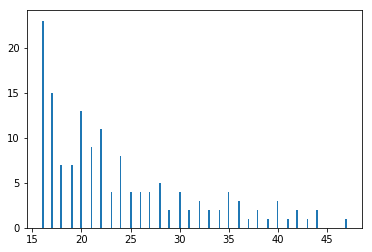

In [2]:
"""
与上面相同但是没有压缩为256，依然为512的大小

"""

import os
import shutil
from time import time

import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage

upper = 200
lower = -200
expand_slice = 6  # 轴向上向外扩张的slice数量
size = 16  # 取样的slice数量
# stride = 1  # 取样的步长
down_scale = 0.5
slice_thickness = 5


# 用来统计最终剩下的slice数量
left_slice_list = []

start_time = time()
# for ct_file in os.listdir(ct_dir):
for i in range(150):

    # 将CT和金标准入读内存
    ct = sitk.ReadImage('/home/yanxin/data_ct/'+str(i) + 'Venous_tra_5mm.nii', sitk.sitkInt16)
    ct_array = sitk.GetArrayFromImage(ct)

    seg = sitk.ReadImage('/home/yanxin/data_ct/'+str(i) + 'Venous_tra_5mm_roi.nii', sitk.sitkInt16)
    seg_array = sitk.GetArrayFromImage(seg)

    seg_array[seg_array > 0] = 1

    # 将灰度值在阈值之外的截断掉  #  这个可以
    ct_array[ct_array > upper] = upper
    ct_array[ct_array < lower] = lower

#     # 对CT和金标准进行插值，插值之后的array依然是int类型
#     # order=3 cubic interpolation:'   1, 0.5 0.5  三次样条插值 0.5的话是下采样了 变成256*256
#     ct_array = ndimage.zoom(ct_array, (ct.GetSpacing()[-1] / slice_thickness, down_scale, down_scale), order=3)

#     # order=0 nearest interpolation:  1,1,1  不变
#     seg_array = ndimage.zoom(seg_array, (ct.GetSpacing()[-1] / slice_thickness,  1, 1), order=0)#也缩小一下吧，看看是否对应

    # 找到肝脏区域开始和结束的slice，并各向外扩张
    z = np.any(seg_array, axis=(1, 2))
    start_slice, end_slice = np.where(z)[0][[0, -1]]  # 就是包含病变的 

    # 两个方向上各扩张个slice，一个方向先设置为6
    if start_slice - expand_slice < 0:
        start_slice = 0
    else:
        start_slice -= expand_slice

    if end_slice + expand_slice >= seg_array.shape[0]:
        end_slice = seg_array.shape[0] - 1
    else:
        end_slice += expand_slice

    # 如果这时候剩下的slice数量不足size，直接放弃，这样的数据很少
    # 放弃的是超级少的，这里是8，其实我们设置成2-4，或者不去也行
    # 算了，我们先不放弃了
#     print(end_slice)
#     print(start_slice)
#     print()
    if end_slice - start_slice + 1 < size:  # 第一种情况，如果小于16了，要扩容
        print('expanding...')
        diff = size - (end_slice - start_slice + 1)
#         print('diff',diff)
        left_right_expand=[(m,diff-m) for m in range(diff+1)]
#         print('list',left_right_expand)
#         print('end_size',end_slice)
#         print('start_slice',start_slice)
# #         expand_value = int(diff / 2)
#         if diff % 2 == 0:
        for left_right in left_right_expand:
            end_slice_now =end_slice+ left_right[1]
            start_slice_now =start_slice- left_right[0]
#         else:
#             end_slice = end_slice + 1 + expand_value
#             start_slice -= expand_value
            if start_slice_now >= 0 and end_slice_now <= ct_array.shape[0] - 1:
                print('success expand')
                end_slice =end_slice_now
                start_slice =start_slice_now
                break

    ct_array = ct_array[start_slice:end_slice + 1, :, :]  # 这是扩张以后的,现在都大于等于16了
#     print(ct_array.shape[0])
    seg_array = seg_array[start_slice:end_slice + 1, :, :]

    print('{} have {} slice left'.format(i, ct_array.shape[0]))
    left_slice_list.append(ct_array.shape[0])


    if ct_array.shape[0] == size:
        new_ct_array = ct_array
        new_seg_array = seg_array
        new_ct = sitk.GetImageFromArray(new_ct_array)
        new_ct.SetDirection(ct.GetDirection())
        new_ct.SetOrigin(ct.GetOrigin())
        new_ct.SetSpacing(ct.GetSpacing())
        new_seg = sitk.GetImageFromArray(new_seg_array)
        new_seg.SetDirection(ct.GetDirection())
        new_seg.SetOrigin(ct.GetOrigin())
        new_seg.SetSpacing(ct.GetSpacing())

        new_ct_name = str(i) + 'input_index0' +'512'+ '.nii'
        new_seg_name = str(i) + 'gt_index0' +'512'+ '.nii'

        sitk.WriteImage(new_ct, '/home/yanxin/sorted_data_16/' + new_ct_name)
        sitk.WriteImage(new_seg, '/home/yanxin/sorted_data_16/' + new_seg_name)

    if ct_array.shape[0] > size and ct_array.shape[0] <= 2 * size:
        new_ct_array0 = ct_array[0:size , :, :]
        new_seg_array0 = seg_array[0:size, :, :]
        new_ct = sitk.GetImageFromArray(new_ct_array0)
        new_ct.SetDirection(ct.GetDirection())
        new_ct.SetOrigin(ct.GetOrigin())
        new_ct.SetSpacing(ct.GetSpacing())
        new_seg = sitk.GetImageFromArray(new_seg_array0)
        new_seg.SetDirection(ct.GetDirection())
        new_seg.SetOrigin(ct.GetOrigin())
        new_seg.SetSpacing(ct.GetSpacing())
        new_ct_name = str(i) + 'input_index0'+'512' + '.nii'
        new_seg_name = str(i) + 'gt_index0'+'512' + '.nii'
        sitk.WriteImage(new_ct, '/home/yanxin/sorted_data_16/' + new_ct_name)
        sitk.WriteImage(new_seg, '/home/yanxin/sorted_data_16/' + new_seg_name)

        new_ct_array1 = ct_array[-size:, :, :]
        new_seg_array1 = seg_array[-size:, :, :]
        new_ct = sitk.GetImageFromArray(new_ct_array1)
        new_ct.SetDirection(ct.GetDirection())
        new_ct.SetOrigin(ct.GetOrigin())
        new_ct.SetSpacing(ct.GetSpacing())
        new_seg = sitk.GetImageFromArray(new_seg_array1)
        new_seg.SetDirection(ct.GetDirection())
        new_seg.SetOrigin(ct.GetOrigin())
        new_seg.SetSpacing(ct.GetSpacing())
        new_ct_name = str(i) + 'input_index1' +'512'+ '.nii'
        new_seg_name = str(i) + 'gt_index1'+'512' + '.nii'
        sitk.WriteImage(new_ct, '/home/yanxin/sorted_data_16/' + new_ct_name)
        sitk.WriteImage(new_seg, '/home/yanxin/sorted_data_16/' + new_seg_name)

    if ct_array.shape[0] > 3 * size:
            print('ct_array.shape[0] >3*size')

    if ct_array.shape[0] <= 3 * size and ct_array.shape[0] > 2 * size:
        new_ct_array0 = ct_array[0:size , :, :]
        new_seg_array0 = seg_array[0:size , :, :]
        new_ct = sitk.GetImageFromArray(new_ct_array0)
        new_ct.SetDirection(ct.GetDirection())
        new_ct.SetOrigin(ct.GetOrigin())
        new_ct.SetSpacing(ct.GetSpacing())
        new_seg = sitk.GetImageFromArray(new_seg_array0)
        new_seg.SetDirection(ct.GetDirection())
        new_seg.SetOrigin(ct.GetOrigin())
        new_seg.SetSpacing(ct.GetSpacing())
        new_ct_name = str(i) + 'input_index0'+'512' + '.nii'
        new_seg_name = str(i) + 'gt_index0'+'512' + '.nii'
        sitk.WriteImage(new_ct, '/home/yanxin/sorted_data_16/' + new_ct_name)
        sitk.WriteImage(new_seg, '/home/yanxin/sorted_data_16/' + new_seg_name)
#         print(int(ct_array.shape[0] / 2))
#         print((size / 2))

        new_ct_array1 = ct_array[int(ct_array.shape[0] / 2) - int(size / 2):int(ct_array.shape[0] / 2) + int(size / 2), :, :]
        new_seg_array1 = seg_array[int(ct_array.shape[0] / 2) - int(size / 2):int(ct_array.shape[0] / 2) + int(size / 2), :,
                         :]
        new_ct = sitk.GetImageFromArray(new_ct_array1)
        new_ct.SetDirection(ct.GetDirection())
        new_ct.SetOrigin(ct.GetOrigin())
        new_ct.SetSpacing(ct.GetSpacing())
        new_seg = sitk.GetImageFromArray(new_seg_array1)
        new_seg.SetDirection(ct.GetDirection())
        new_seg.SetOrigin(ct.GetOrigin())
        new_seg.SetSpacing(ct.GetSpacing())
        new_ct_name = str(i) + 'input_index1'+'512' + '.nii'
        new_seg_name = str(i) + 'gt_index1'+'512' + '.nii'
        sitk.WriteImage(new_ct, '/home/yanxin/sorted_data_16/' + new_ct_name)
        sitk.WriteImage(new_seg, '/home/yanxin/sorted_data_16/' + new_seg_name)

        new_ct_array2 = ct_array[-size:, :, :]
        new_seg_array2 = seg_array[-size:, :, :]
        new_ct = sitk.GetImageFromArray(new_ct_array2)
        new_ct.SetDirection(ct.GetDirection())
        new_ct.SetOrigin(ct.GetOrigin())
        new_ct.SetSpacing(ct.GetSpacing())
        new_seg = sitk.GetImageFromArray(new_seg_array2)
        new_seg.SetDirection(ct.GetDirection())
        new_seg.SetOrigin(ct.GetOrigin())
        new_seg.SetSpacing(ct.GetSpacing())
        new_ct_name = str(i) + 'input_index2' +'512'+ '.nii'
        new_seg_name = str(i) + 'gt_index2'+'512' + '.nii'
        sitk.WriteImage(new_ct, '/home/yanxin/sorted_data_16/' + new_ct_name)
        sitk.WriteImage(new_seg, '/home/yanxin/sorted_data_16/' + new_seg_name)

        # 每处理完一个数据，打印一次已经使用的时间
    print('already use {:.3f} min'.format((time() - start_time) / 60))
    print('-----------')

left_slice_list = np.array(left_slice_list)

plt.hist(left_slice_list, 200, rwidth=1)
plt.show()

In [56]:
"""
与上面相同，只调整了testdata用于模型检验，256大小
"""

import os
import shutil
from time import time

import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage

upper = 200
lower = -200
expand_slice = 6  # 轴向上向外扩张的slice数量
size = 16  # 取样的slice数量
# stride = 1  # 取样的步长
down_scale = 0.5
slice_thickness = 5


# 用来统计最终剩下的slice数量
left_slice_list = []

start_time = time()
# for ct_file in os.listdir(ct_dir):
for i in range(120,150):

    # 将CT和金标准入读内存
    ct = sitk.ReadImage('/home/yanxin/data_ct/'+str(i) + 'Venous_tra_5mm.nii', sitk.sitkInt16)
    ct_array = sitk.GetArrayFromImage(ct)

    seg = sitk.ReadImage('/home/yanxin/data_ct/'+str(i) + 'Venous_tra_5mm_roi.nii', sitk.sitkInt16)
    seg_array = sitk.GetArrayFromImage(seg)

    seg_array[seg_array > 0] = 1

    # 将灰度值在阈值之外的截断掉  #  这个可以
    ct_array[ct_array > upper] = upper
    ct_array[ct_array < lower] = lower

    # 对CT和金标准进行插值，插值之后的array依然是int类型
    # order=3 cubic interpolation:'   1, 0.5 0.5  三次样条插值 0.5的话是下采样了 变成256*256
    ct_array = ndimage.zoom(ct_array, (ct.GetSpacing()[-1] / slice_thickness, down_scale, down_scale), order=3)

    # order=0 nearest interpolation:  1,1,1  不变
    seg_array = ndimage.zoom(seg_array, (ct.GetSpacing()[-1] / slice_thickness,  down_scale, down_scale), order=0)#也缩小一下吧，看看是否对应


    new_ct_array = ct_array
    new_seg_array = seg_array
    new_ct = sitk.GetImageFromArray(new_ct_array)
    new_ct.SetDirection(ct.GetDirection())
    new_ct.SetOrigin(ct.GetOrigin())
    new_ct.SetSpacing(ct.GetSpacing())
    new_seg = sitk.GetImageFromArray(new_seg_array)
    new_seg.SetDirection(ct.GetDirection())
    new_seg.SetOrigin(ct.GetOrigin())
    new_seg.SetSpacing(ct.GetSpacing())

    new_ct_name = str(i) + 'input256' + '.nii'
    new_seg_name = str(i) + 'gt256' + '.nii'

    sitk.WriteImage(new_ct, '/home/yanxin/testdata/' + new_ct_name)
    sitk.WriteImage(new_seg, '/home/yanxin/testdata/' + new_seg_name)

    print('already use {:.3f} min'.format((time() - start_time) / 60))
    print('-----------')



already use 0.019 min
-----------
already use 0.043 min
-----------
already use 0.064 min
-----------
already use 0.084 min
-----------
already use 0.104 min
-----------
already use 0.151 min
-----------
already use 0.173 min
-----------
already use 0.191 min
-----------
already use 0.211 min
-----------
already use 0.233 min
-----------
already use 0.253 min
-----------
already use 0.273 min
-----------
already use 0.299 min
-----------
already use 0.320 min
-----------
already use 0.339 min
-----------
already use 0.356 min
-----------
already use 0.380 min
-----------
already use 0.405 min
-----------
already use 0.446 min
-----------
already use 0.461 min
-----------
already use 0.481 min
-----------
already use 0.498 min
-----------
already use 0.516 min
-----------
already use 0.534 min
-----------
already use 0.552 min
-----------
already use 0.569 min
-----------
already use 0.590 min
-----------
already use 0.612 min
-----------
already use 0.632 min
-----------
already use 0.

In [3]:
"""
与上面相同，只调整了testdata用于模型检验，512大小

"""

import os
import shutil
from time import time

import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage

upper = 200
lower = -200
expand_slice = 6  # 轴向上向外扩张的slice数量
size = 16  # 取样的slice数量
# stride = 1  # 取样的步长
down_scale = 0.5
slice_thickness = 5


# 用来统计最终剩下的slice数量
left_slice_list = []

start_time = time()
# for ct_file in os.listdir(ct_dir):
for i in range(120,150):

    # 将CT和金标准入读内存
    ct = sitk.ReadImage('/home/yanxin/data_ct/'+str(i) + 'Venous_tra_5mm.nii', sitk.sitkInt16)
    ct_array = sitk.GetArrayFromImage(ct)

    seg = sitk.ReadImage('/home/yanxin/data_ct/'+str(i) + 'Venous_tra_5mm_roi.nii', sitk.sitkInt16)
    seg_array = sitk.GetArrayFromImage(seg)

    seg_array[seg_array > 0] = 1

    # 将灰度值在阈值之外的截断掉  #  这个可以
    ct_array[ct_array > upper] = upper
    ct_array[ct_array < lower] = lower

    # 对CT和金标准进行插值，插值之后的array依然是int类型
    # order=3 cubic interpolation:'   1, 0.5 0.5  三次样条插值 0.5的话是下采样了 变成256*256
#     ct_array = ndimage.zoom(ct_array, (ct.GetSpacing()[-1] / slice_thickness, down_scale, down_scale), order=3)

#     # order=0 nearest interpolation:  1,1,1  不变
#     seg_array = ndimage.zoom(seg_array, (ct.GetSpacing()[-1] / slice_thickness,  down_scale, down_scale), order=0)#也缩小一下吧，看看是否对应


    new_ct_array = ct_array
    new_seg_array = seg_array
    new_ct = sitk.GetImageFromArray(new_ct_array)
    new_ct.SetDirection(ct.GetDirection())
    new_ct.SetOrigin(ct.GetOrigin())
    new_ct.SetSpacing(ct.GetSpacing())
    new_seg = sitk.GetImageFromArray(new_seg_array)
    new_seg.SetDirection(ct.GetDirection())
    new_seg.SetOrigin(ct.GetOrigin())
    new_seg.SetSpacing(ct.GetSpacing())

    new_ct_name = str(i) + 'input512' + '.nii'
    new_seg_name = str(i) + 'gt512' + '.nii'

    sitk.WriteImage(new_ct, '/home/yanxin/testdata/' + new_ct_name)
    sitk.WriteImage(new_seg, '/home/yanxin/testdata/' + new_seg_name)

    print('already use {:.3f} min'.format((time() - start_time) / 60))
    print('-----------')



already use 0.003 min
-----------
already use 0.006 min
-----------
already use 0.009 min
-----------
already use 0.011 min
-----------
already use 0.014 min
-----------
already use 0.021 min
-----------
already use 0.024 min
-----------
already use 0.026 min
-----------
already use 0.029 min
-----------
already use 0.031 min
-----------
already use 0.034 min
-----------
already use 0.036 min
-----------
already use 0.040 min
-----------
already use 0.042 min
-----------
already use 0.045 min
-----------
already use 0.047 min
-----------
already use 0.051 min
-----------
already use 0.054 min
-----------
already use 0.061 min
-----------
already use 0.063 min
-----------
already use 0.066 min
-----------
already use 0.068 min
-----------
already use 0.070 min
-----------
already use 0.073 min
-----------
already use 0.075 min
-----------
already use 0.078 min
-----------
already use 0.080 min
-----------
already use 0.083 min
-----------
already use 0.086 min
-----------
already use 0.

0


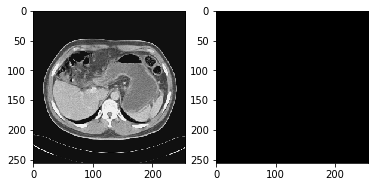

1


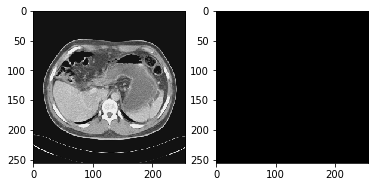

2


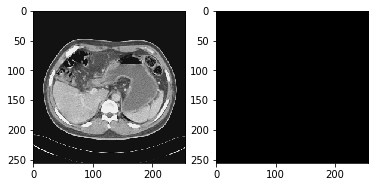

3


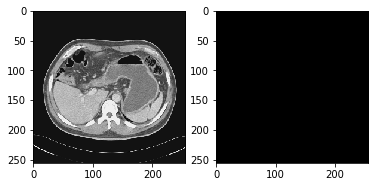

4


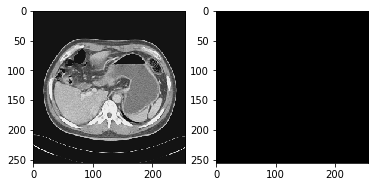

5


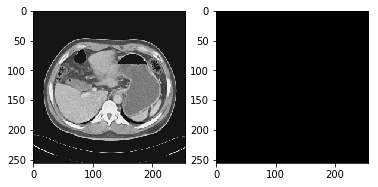

6


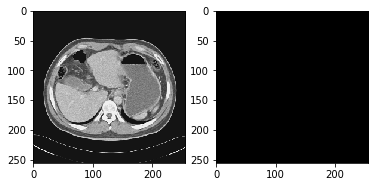

7


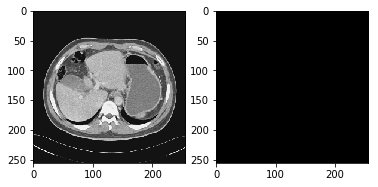

8


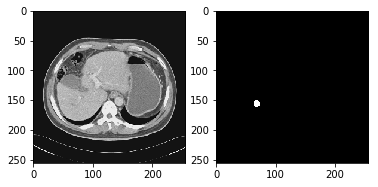

9


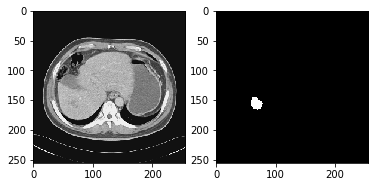

10


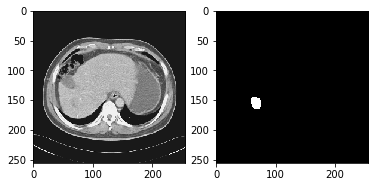

11


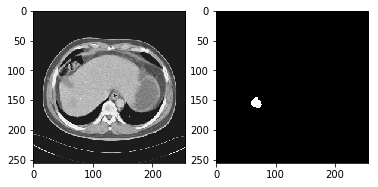

12


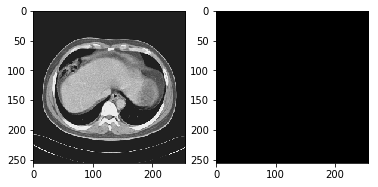

13


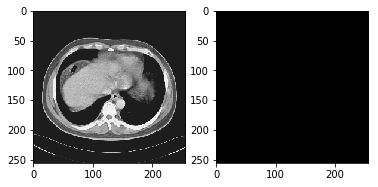

14


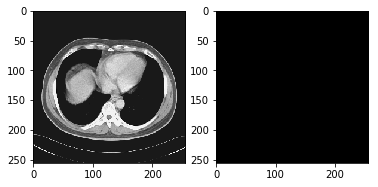

15


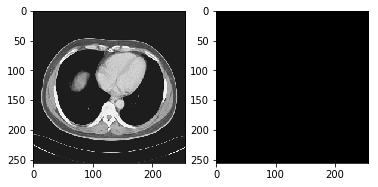

In [54]:

# 这个是可视化看一看

import os
import shutil
from time import time

import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
aa=[]
# for i in range(150):

# #     # 将CT和金标准入读内存
#     try:
#         ct = sitk.ReadImage('/home/yanxin/sorted_data_16/'+str(i) + 'input_index0', sitk.sitkInt16)
#         ct_array = sitk.GetArrayFromImage(ct)
#         print(ct_array.shape)
#         aa.append(ct_array.shape[0])
#     except:pass
# print(len(aa))
ct = sitk.ReadImage('/home/yanxin/sorted_data_16/'+str(42) + 'input_index0',  sitk.sitkInt16)
ct_array = sitk.GetArrayFromImage(ct)
seg = sitk.ReadImage('/home/yanxin/sorted_data_16/'+str(42) + 'gt_index0',  sitk.sitkInt16)
seg_array = sitk.GetArrayFromImage(seg)
for i in range(16):
    print(i)
    
# #         print(a[0].shape)
# #         print(b.shape)
# #         print(a[0][0])
    plt.subplot(1,2,1)
    plt.imshow(ct_array[i],cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(seg_array[i],cmap='gray')
    plt.show()

0 have 20 slice left
already use 0.021 min
-----------
expanding...
success expand
1 have 16 slice left
already use 0.042 min
-----------
2 have 17 slice left
already use 0.064 min
-----------
3 have 40 slice left
already use 0.091 min
-----------
4 have 28 slice left
already use 0.112 min
-----------
5 have 36 slice left
already use 0.136 min
-----------
6 have 35 slice left
already use 0.154 min
-----------
7 have 16 slice left
already use 0.174 min
-----------
expanding...
success expand
8 have 16 slice left
already use 0.197 min
-----------
expanding...
success expand
9 have 16 slice left
already use 0.218 min
-----------
10 have 35 slice left
already use 0.236 min
-----------
11 have 35 slice left
already use 0.257 min
-----------
12 have 23 slice left
already use 0.279 min
-----------
13 have 27 slice left
already use 0.301 min
-----------
14 have 29 slice left
already use 0.324 min
-----------
15 have 25 slice left
already use 0.344 min
-----------
16 have 17 slice left
already 

139 have 26 slice left
already use 3.082 min
-----------
140 have 24 slice left
already use 3.104 min
-----------
141 have 17 slice left
already use 3.122 min
-----------
142 have 22 slice left
already use 3.142 min
-----------
143 have 20 slice left
already use 3.162 min
-----------
144 have 31 slice left
already use 3.180 min
-----------
145 have 19 slice left
already use 3.199 min
-----------
146 have 41 slice left
already use 3.222 min
-----------
147 have 29 slice left
already use 3.246 min
-----------
148 have 43 slice left
already use 3.268 min
-----------
149 have 28 slice left
already use 3.296 min
-----------


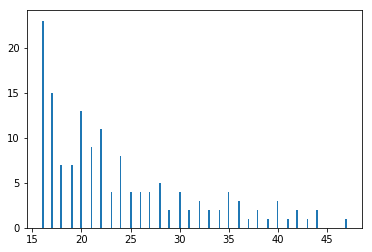

In [69]:
'''

这个脚本是放到两个文件夹的两个文件夹里
train input gt
test input gt

'''

import os
import shutil
from time import time

import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage

upper = 200
lower = -200
expand_slice = 6  # 轴向上向外扩张的slice数量
size = 16  # 取样的slice数量
stride = 1  # 取样的步长
down_scale = 0.5
slice_thickness = 5


# 用来统计最终剩下的slice数量
left_slice_list = []

start_time = time()
# for ct_file in os.listdir(ct_dir):
for i in range(120):

    # 将CT和金标准入读内存
    ct = sitk.ReadImage('/home/yanxin/data_ct/'+str(i) + 'Venous_tra_5mm.nii', sitk.sitkInt16)
    ct_array = sitk.GetArrayFromImage(ct)

    seg = sitk.ReadImage('/home/yanxin/data_ct/'+str(i) + 'Venous_tra_5mm_roi.nii', sitk.sitkInt16)
    seg_array = sitk.GetArrayFromImage(seg)

    seg_array[seg_array > 0] = 1

    # 将灰度值在阈值之外的截断掉  #  这个可以
    ct_array[ct_array > upper] = upper
    ct_array[ct_array < lower] = lower

    # 对CT和金标准进行插值，插值之后的array依然是int类型
    # order=3 cubic interpolation:'   1, 0.5 0.5  三次样条插值 0.5的话是下采样了 变成256*256
    ct_array = ndimage.zoom(ct_array, (ct.GetSpacing()[-1] / slice_thickness, down_scale, down_scale), order=3)

    # order=0 nearest interpolation:  1,1,1  不变
    seg_array = ndimage.zoom(seg_array, (ct.GetSpacing()[-1] / slice_thickness,  1, 1), order=0)#也缩小一下吧，看看是否对应

    # 找到肝脏区域开始和结束的slice，并各向外扩张
    z = np.any(seg_array, axis=(1, 2))
    start_slice, end_slice = np.where(z)[0][[0, -1]]  # 就是包含病变的
    # 两个方向上各扩张个slice，一个方向就先设置为6
    if start_slice - expand_slice < 0:
        start_slice = 0
    else:
        start_slice -= expand_slice

    if end_slice + expand_slice >= seg_array.shape[0]:
        end_slice = seg_array.shape[0] - 1
    else:
        end_slice += expand_slice

    # 如果这时候剩下的slice数量不足size，直接放弃，这样的数据很少
    # 放弃的是超级少的，这里是8，其实我们设置成2-4，或者不去也行
    # 算了，我们先不放弃了
#     print(end_slice)
#     print(start_slice)
#     print()
    if end_slice - start_slice + 1 < size:  # 第一种情况，如果小于16了，要扩容
        print('expanding...')
        diff = size - (end_slice - start_slice + 1)
#         print('diff',diff)
        left_right_expand=[(m,diff-m) for m in range(diff+1)]
#         print('list',left_right_expand)
#         print('end_size',end_slice)
#         print('start_slice',start_slice)
# #         expand_value = int(diff / 2)
#         if diff % 2 == 0:
        for left_right in left_right_expand:
            end_slice_now =end_slice+ left_right[1]
            start_slice_now =start_slice- left_right[0]
#         else:
#             end_slice = end_slice + 1 + expand_value
#             start_slice -= expand_value
            if start_slice_now >= 0 and end_slice_now <= ct_array.shape[0] - 1:
                print('success expand')
                end_slice =end_slice_now
                start_slice =start_slice_now
                break

    ct_array = ct_array[start_slice:end_slice + 1, :, :]  # 这是扩张以后的,现在都大于等于16了
#     print(ct_array.shape[0])
    seg_array = seg_array[start_slice:end_slice + 1, :, :]

    print('{} have {} slice left'.format(i, ct_array.shape[0]))
    left_slice_list.append(ct_array.shape[0])


    if ct_array.shape[0] == size:
        new_ct_array = ct_array
        new_seg_array = seg_array
        new_ct = sitk.GetImageFromArray(new_ct_array)
        new_ct.SetDirection(ct.GetDirection())
        new_ct.SetOrigin(ct.GetOrigin())
        new_ct.SetSpacing(ct.GetSpacing())
        new_seg = sitk.GetImageFromArray(new_seg_array)
        new_seg.SetDirection(ct.GetDirection())
        new_seg.SetOrigin(ct.GetOrigin())
        new_seg.SetSpacing(ct.GetSpacing())

        new_ct_name = str(i) + 'input_index0' + '.nii'
        new_seg_name = str(i) + 'gt_index0' + '.nii'

        sitk.WriteImage(new_ct, '/home/yanxin/sorted_data_16/train/input/' + new_ct_name)
        sitk.WriteImage(new_seg, '/home/yanxin/sorted_data_16/train/gt/' + new_seg_name)

    if ct_array.shape[0] > size and ct_array.shape[0] <= 2 * size:
        new_ct_array0 = ct_array[0:size , :, :]
        new_seg_array0 = seg_array[0:size, :, :]
        new_ct = sitk.GetImageFromArray(new_ct_array0)
        new_ct.SetDirection(ct.GetDirection())
        new_ct.SetOrigin(ct.GetOrigin())
        new_ct.SetSpacing(ct.GetSpacing())
        new_seg = sitk.GetImageFromArray(new_seg_array0)
        new_seg.SetDirection(ct.GetDirection())
        new_seg.SetOrigin(ct.GetOrigin())
        new_seg.SetSpacing(ct.GetSpacing())
        new_ct_name = str(i) + 'input_index0' + '.nii'
        new_seg_name = str(i) + 'gt_index0' + '.nii'
        sitk.WriteImage(new_ct, '/home/yanxin/sorted_data_16/train/input/' + new_ct_name)
        sitk.WriteImage(new_seg, '/home/yanxin/sorted_data_16/train/gt/' + new_seg_name)

        new_ct_array1 = ct_array[-size:, :, :]
        new_seg_array1 = seg_array[-size:, :, :]
        new_ct = sitk.GetImageFromArray(new_ct_array1)
        new_ct.SetDirection(ct.GetDirection())
        new_ct.SetOrigin(ct.GetOrigin())
        new_ct.SetSpacing(ct.GetSpacing())
        new_seg = sitk.GetImageFromArray(new_seg_array1)
        new_seg.SetDirection(ct.GetDirection())
        new_seg.SetOrigin(ct.GetOrigin())
        new_seg.SetSpacing(ct.GetSpacing())
        new_ct_name = str(i) + 'input_index1' + '.nii'
        new_seg_name = str(i) + 'gt_index1' + '.nii'
        sitk.WriteImage(new_ct, '/home/yanxin/sorted_data_16/train/input/' + new_ct_name)
        sitk.WriteImage(new_seg, '/home/yanxin/sorted_data_16/train/gt/' + new_seg_name)

    if ct_array.shape[0] > 3 * size:
            print('ct_array.shape[0] >3*size')

    if ct_array.shape[0] <= 3 * size and ct_array.shape[0] > 2 * size:
        new_ct_array0 = ct_array[0:size , :, :]
        new_seg_array0 = seg_array[0:size , :, :]
        new_ct = sitk.GetImageFromArray(new_ct_array0)
        new_ct.SetDirection(ct.GetDirection())
        new_ct.SetOrigin(ct.GetOrigin())
        new_ct.SetSpacing(ct.GetSpacing())
        new_seg = sitk.GetImageFromArray(new_seg_array0)
        new_seg.SetDirection(ct.GetDirection())
        new_seg.SetOrigin(ct.GetOrigin())
        new_seg.SetSpacing(ct.GetSpacing())
        new_ct_name = str(i) + 'input_index0' + '.nii'
        new_seg_name = str(i) + 'gt_index0' + '.nii'
        sitk.WriteImage(new_ct, '/home/yanxin/sorted_data_16/train/input/' + new_ct_name)
        sitk.WriteImage(new_seg, '/home/yanxin/sorted_data_16/train/gt/' + new_seg_name)
#         print(int(ct_array.shape[0] / 2))
#         print((size / 2))

        new_ct_array1 = ct_array[int(ct_array.shape[0] / 2) - int(size / 2):int(ct_array.shape[0] / 2) + int(size / 2), :, :]
        new_seg_array1 = seg_array[int(ct_array.shape[0] / 2) - int(size / 2):int(ct_array.shape[0] / 2) + int(size / 2), :,
                         :]
        new_ct = sitk.GetImageFromArray(new_ct_array1)
        new_ct.SetDirection(ct.GetDirection())
        new_ct.SetOrigin(ct.GetOrigin())
        new_ct.SetSpacing(ct.GetSpacing())
        new_seg = sitk.GetImageFromArray(new_seg_array1)
        new_seg.SetDirection(ct.GetDirection())
        new_seg.SetOrigin(ct.GetOrigin())
        new_seg.SetSpacing(ct.GetSpacing())
        new_ct_name = str(i) + 'input_index1' + '.nii'
        new_seg_name = str(i) + 'gt_index1' + '.nii'
        sitk.WriteImage(new_ct, '/home/yanxin/sorted_data_16/train/input/' + new_ct_name)
        sitk.WriteImage(new_seg, '/home/yanxin/sorted_data_16/train/gt/' + new_seg_name)

        new_ct_array2 = ct_array[-size:, :, :]
        new_seg_array2 = seg_array[-size:, :, :]
        new_ct = sitk.GetImageFromArray(new_ct_array2)
        new_ct.SetDirection(ct.GetDirection())
        new_ct.SetOrigin(ct.GetOrigin())
        new_ct.SetSpacing(ct.GetSpacing())
        new_seg = sitk.GetImageFromArray(new_seg_array2)
        new_seg.SetDirection(ct.GetDirection())
        new_seg.SetOrigin(ct.GetOrigin())
        new_seg.SetSpacing(ct.GetSpacing())
        new_ct_name = str(i) + 'input_index2' + '.nii'
        new_seg_name = str(i) + 'gt_index2' + '.nii'
        sitk.WriteImage(new_ct, '/home/yanxin/sorted_data_16/train/input/' + new_ct_name)
        sitk.WriteImage(new_seg, '/home/yanxin/sorted_data_16/train/gt/' + new_seg_name)

        # 每处理完一个数据，打印一次已经使用的时间
    print('already use {:.3f} min'.format((time() - start_time) / 60))
    print('-----------')
for i in range(120,150):

    # 将CT和金标准入读内存
    ct = sitk.ReadImage('/home/yanxin/data_ct/'+str(i) + 'Venous_tra_5mm.nii', sitk.sitkInt16)
    ct_array = sitk.GetArrayFromImage(ct)

    seg = sitk.ReadImage('/home/yanxin/data_ct/'+str(i) + 'Venous_tra_5mm_roi.nii', sitk.sitkInt16)
    seg_array = sitk.GetArrayFromImage(seg)

    seg_array[seg_array > 0] = 1

    # 将灰度值在阈值之外的截断掉  #  这个可以
    ct_array[ct_array > upper] = upper
    ct_array[ct_array < lower] = lower

    # 对CT和金标准进行插值，插值之后的array依然是int类型
    # order=3 cubic interpolation:'   1, 0.5 0.5  三次样条插值 0.5的话是下采样了 变成256*256
    ct_array = ndimage.zoom(ct_array, (ct.GetSpacing()[-1] / slice_thickness, down_scale, down_scale), order=3)

    # order=0 nearest interpolation:  1,1,1  不变
    seg_array = ndimage.zoom(seg_array, (ct.GetSpacing()[-1] / slice_thickness,  1, 1), order=0)#也缩小一下吧，看看是否对应

    # 找到肝脏区域开始和结束的slice，并各向外扩张
    z = np.any(seg_array, axis=(1, 2))
    start_slice, end_slice = np.where(z)[0][[0, -1]]  

    # 两个方向上各扩张个slice，一个方向先设置为6
    if start_slice - expand_slice < 0:
        start_slice = 0
    else:
        start_slice -= expand_slice

    if end_slice + expand_slice >= seg_array.shape[0]:
        end_slice = seg_array.shape[0] - 1
    else:
        end_slice += expand_slice

    # 如果这时候剩下的slice数量不足size，直接放弃，这样的数据很少
    # 放弃的是超级少的，这里是8，其实我们设置成2-4，或者不去也行
    # 算了，我们先不放弃了
#     print(end_slice)
#     print(start_slice)
#     print()
    if end_slice - start_slice + 1 < size:  # 第一种情况，如果小于16了，要扩容
        print('expanding...')
        diff = size - (end_slice - start_slice + 1)
#         print('diff',diff)
        left_right_expand=[(m,diff-m) for m in range(diff+1)]
#         print('list',left_right_expand)
#         print('end_size',end_slice)
#         print('start_slice',start_slice)
# #         expand_value = int(diff / 2)
#         if diff % 2 == 0:
        for left_right in left_right_expand:
            end_slice_now =end_slice+ left_right[1]
            start_slice_now =start_slice- left_right[0]
#         else:
#             end_slice = end_slice + 1 + expand_value
#             start_slice -= expand_value
            if start_slice_now >= 0 and end_slice_now <= ct_array.shape[0] - 1:
                print('success expand')
                end_slice =end_slice_now
                start_slice =start_slice_now
                break

    ct_array = ct_array[start_slice:end_slice + 1, :, :]  # 这是扩张以后的,现在都大于等于16了
#     print(ct_array.shape[0])
    seg_array = seg_array[start_slice:end_slice + 1, :, :]

    print('{} have {} slice left'.format(i, ct_array.shape[0]))
    left_slice_list.append(ct_array.shape[0])


    if ct_array.shape[0] == size:
        new_ct_array = ct_array
        new_seg_array = seg_array
        new_ct = sitk.GetImageFromArray(new_ct_array)
        new_ct.SetDirection(ct.GetDirection())
        new_ct.SetOrigin(ct.GetOrigin())
        new_ct.SetSpacing(ct.GetSpacing())
        new_seg = sitk.GetImageFromArray(new_seg_array)
        new_seg.SetDirection(ct.GetDirection())
        new_seg.SetOrigin(ct.GetOrigin())
        new_seg.SetSpacing(ct.GetSpacing())

        new_ct_name = str(i) + 'input_index0' + '.nii'
        new_seg_name = str(i) + 'gt_index0' + '.nii'

        sitk.WriteImage(new_ct, '/home/yanxin/sorted_data_16/test/input/' + new_ct_name)
        sitk.WriteImage(new_seg, '/home/yanxin/sorted_data_16/test/gt/' + new_seg_name)

    if ct_array.shape[0] > size and ct_array.shape[0] <= 2 * size:
        new_ct_array0 = ct_array[0:size , :, :]
        new_seg_array0 = seg_array[0:size, :, :]
        new_ct = sitk.GetImageFromArray(new_ct_array0)
        new_ct.SetDirection(ct.GetDirection())
        new_ct.SetOrigin(ct.GetOrigin())
        new_ct.SetSpacing(ct.GetSpacing())
        new_seg = sitk.GetImageFromArray(new_seg_array0)
        new_seg.SetDirection(ct.GetDirection())
        new_seg.SetOrigin(ct.GetOrigin())
        new_seg.SetSpacing(ct.GetSpacing())
        new_ct_name = str(i) + 'input_index0' + '.nii'
        new_seg_name = str(i) + 'gt_index0' + '.nii'
        sitk.WriteImage(new_ct, '/home/yanxin/sorted_data_16/test/input/' + new_ct_name)
        sitk.WriteImage(new_seg, '/home/yanxin/sorted_data_16/test/gt/' + new_seg_name)

        new_ct_array1 = ct_array[-size:, :, :]
        new_seg_array1 = seg_array[-size:, :, :]
        new_ct = sitk.GetImageFromArray(new_ct_array1)
        new_ct.SetDirection(ct.GetDirection())
        new_ct.SetOrigin(ct.GetOrigin())
        new_ct.SetSpacing(ct.GetSpacing())
        new_seg = sitk.GetImageFromArray(new_seg_array1)
        new_seg.SetDirection(ct.GetDirection())
        new_seg.SetOrigin(ct.GetOrigin())
        new_seg.SetSpacing(ct.GetSpacing())
        new_ct_name = str(i) + 'input_index1' + '.nii'
        new_seg_name = str(i) + 'gt_index1' + '.nii'
        sitk.WriteImage(new_ct, '/home/yanxin/sorted_data_16/test/input/' + new_ct_name)
        sitk.WriteImage(new_seg, '/home/yanxin/sorted_data_16/test/gt/' + new_seg_name)

    if ct_array.shape[0] > 3 * size:
            print('ct_array.shape[0] >3*size')

    if ct_array.shape[0] <= 3 * size and ct_array.shape[0] > 2 * size:
        new_ct_array0 = ct_array[0:size , :, :]
        new_seg_array0 = seg_array[0:size , :, :]
        new_ct = sitk.GetImageFromArray(new_ct_array0)
        new_ct.SetDirection(ct.GetDirection())
        new_ct.SetOrigin(ct.GetOrigin())
        new_ct.SetSpacing(ct.GetSpacing())
        new_seg = sitk.GetImageFromArray(new_seg_array0)
        new_seg.SetDirection(ct.GetDirection())
        new_seg.SetOrigin(ct.GetOrigin())
        new_seg.SetSpacing(ct.GetSpacing())
        new_ct_name = str(i) + 'input_index0' + '.nii'
        new_seg_name = str(i) + 'gt_index0' + '.nii'
        sitk.WriteImage(new_ct, '/home/yanxin/sorted_data_16/test/input/' + new_ct_name)
        sitk.WriteImage(new_seg, '/home/yanxin/sorted_data_16/test/gt/' + new_seg_name)
#         print(int(ct_array.shape[0] / 2))
#         print((size / 2))

        new_ct_array1 = ct_array[int(ct_array.shape[0] / 2) - int(size / 2):int(ct_array.shape[0] / 2) + int(size / 2), :, :]
        new_seg_array1 = seg_array[int(ct_array.shape[0] / 2) - int(size / 2):int(ct_array.shape[0] / 2) + int(size / 2), :,
                         :]
        new_ct = sitk.GetImageFromArray(new_ct_array1)
        new_ct.SetDirection(ct.GetDirection())
        new_ct.SetOrigin(ct.GetOrigin())
        new_ct.SetSpacing(ct.GetSpacing())
        new_seg = sitk.GetImageFromArray(new_seg_array1)
        new_seg.SetDirection(ct.GetDirection())
        new_seg.SetOrigin(ct.GetOrigin())
        new_seg.SetSpacing(ct.GetSpacing())
        new_ct_name = str(i) + 'input_index1' + '.nii'
        new_seg_name = str(i) + 'gt_index1' + '.nii'
        sitk.WriteImage(new_ct, '/home/yanxin/sorted_data_16/test/input/' + new_ct_name)
        sitk.WriteImage(new_seg, '/home/yanxin/sorted_data_16/test/gt/' + new_seg_name)

        new_ct_array2 = ct_array[-size:, :, :]
        new_seg_array2 = seg_array[-size:, :, :]
        new_ct = sitk.GetImageFromArray(new_ct_array2)
        new_ct.SetDirection(ct.GetDirection())
        new_ct.SetOrigin(ct.GetOrigin())
        new_ct.SetSpacing(ct.GetSpacing())
        new_seg = sitk.GetImageFromArray(new_seg_array2)
        new_seg.SetDirection(ct.GetDirection())
        new_seg.SetOrigin(ct.GetOrigin())
        new_seg.SetSpacing(ct.GetSpacing())
        new_ct_name = str(i) + 'input_index2' + '.nii'
        new_seg_name = str(i) + 'gt_index2' + '.nii'
        sitk.WriteImage(new_ct, '/home/yanxin/sorted_data_16/test/input/' + new_ct_name)
        sitk.WriteImage(new_seg, '/home/yanxin/sorted_data_16/test/gt/' + new_seg_name)

        # 每处理完一个数据，打印一次已经使用的时间
    print('already use {:.3f} min'.format((time() - start_time) / 60))
    print('-----------')
left_slice_list = np.array(left_slice_list)

plt.hist(left_slice_list, 200, rwidth=1)
plt.show()

In [70]:
'''

这个脚本是放到两个文件夹的两个文件夹里
用于3D Vnet模型，直训练病变周边切片
引入步长为1，来扩增训练集
train input gt
test input gt

'''

import os
import shutil
from time import time

import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage

upper = 200
lower = -200
expand_slice = 6  # 轴向上向外扩张的slice数量
size = 16  # 取样的slice数量
stride = 1  # 取样的步长
down_scale = 0.5
slice_thickness = 5


# 用来统计最终剩下的slice数量
left_slice_list = []

start_time = time()
# for ct_file in os.listdir(ct_dir):
for i in range(120):

    # 将CT和金标准入读内存
    ct = sitk.ReadImage('/home/yanxin/data_ct/'+str(i) + 'Venous_tra_5mm.nii', sitk.sitkInt16)
    ct_array = sitk.GetArrayFromImage(ct)

    seg = sitk.ReadImage('/home/yanxin/data_ct/'+str(i) + 'Venous_tra_5mm_roi.nii', sitk.sitkInt16)
    seg_array = sitk.GetArrayFromImage(seg)

    # 将金标准中肝脏和肝肿瘤的标签融合为一个  # 这个我们不容，看目的
    seg_array[seg_array > 0] = 1

    # 将灰度值在阈值之外的截断掉  #  这个可以
    ct_array[ct_array > upper] = upper
    ct_array[ct_array < lower] = lower

    # 对CT和金标准进行插值，插值之后的array依然是int类型
    # order=3 cubic interpolation:'   1, 0.5 0.5  三次样条插值 0.5的话是下采样了 变成256*256
    ct_array = ndimage.zoom(ct_array, (ct.GetSpacing()[-1] / slice_thickness, down_scale, down_scale), order=3)
    
    
    # order=0 nearest interpolation:  1,1,1  已经验证是不变
    seg_array = ndimage.zoom(seg_array, (ct.GetSpacing()[-1] / slice_thickness,  1, 1), order=0)#也缩小一下吧，看看是否对应


    # 找到肝脏区域开始和结束的slice，并各向外扩张
    z = np.any(seg_array, axis=(1, 2))
    start_slice, end_slice = np.where(z)[0][[0, -1]]  

    # 两个方向上各扩张个slice，一个方向先设置为6
    if start_slice - expand_slice < 0:
        start_slice = 0
    else:
        start_slice -= expand_slice

    if end_slice + expand_slice >= seg_array.shape[0]:
        end_slice = seg_array.shape[0] - 1
    else:
        end_slice += expand_slice

    # 如果这时候剩下的slice数量不足size，直接放弃，这样的数据很少
    # 放弃的是超级少的，这里是8，其实我们设置成2-4，或者不去也行
    # 算了，我们先不放弃了
#     print(end_slice)
#     print(start_slice)
#     print()
    if end_slice - start_slice + 1 < size:  # 第一种情况，如果小于16了，要扩容
        print('expanding...')
        diff = size - (end_slice - start_slice + 1)
#         print('diff',diff)
        left_right_expand=[(m,diff-m) for m in range(diff+1)]
#         print('list',left_right_expand)
#         print('end_size',end_slice)
#         print('start_slice',start_slice)
# #         expand_value = int(diff / 2)
#         if diff % 2 == 0:
        for left_right in left_right_expand:
            end_slice_now =end_slice+ left_right[1]
            start_slice_now =start_slice- left_right[0]
#         else:
#             end_slice = end_slice + 1 + expand_value
#             start_slice -= expand_value
            if start_slice_now >= 0 and end_slice_now <= ct_array.shape[0] - 1:
                print('success expand')
                end_slice =end_slice_now
                start_slice =start_slice_now
                break

    ct_array = ct_array[start_slice:end_slice + 1, :, :]  # 这是扩张以后的,现在都大于等于16了
#     print(ct_array.shape[0])
    seg_array = seg_array[start_slice:end_slice + 1, :, :]

    print('{} have {} slice left'.format(i, ct_array.shape[0]))
    left_slice_list.append(ct_array.shape[0])

    # 在轴向上按照一定的步长进行切块取样，并将结果保存为nii数据
    # 这里在自己造NII   隔1个步长造一个，厚度就是size(16)
    start_slice = 0
    end_slice = 15

        
    file_index=0
    while end_slice <= ct_array.shape[0] - 1:

        new_ct_array = ct_array[start_slice:end_slice + 1, :, :]
        new_seg_array = seg_array[start_slice:end_slice + 1, :, :]

        new_ct = sitk.GetImageFromArray(new_ct_array)

        new_ct.SetDirection(ct.GetDirection())
        new_ct.SetOrigin(ct.GetOrigin())
        new_ct.SetSpacing((ct.GetSpacing()))

        new_seg = sitk.GetImageFromArray(new_seg_array)

        new_seg.SetDirection(ct.GetDirection())
        new_seg.SetOrigin(ct.GetOrigin())
        new_seg.SetSpacing((ct.GetSpacing()))

        new_ct_name = 'input' + str(i)+'index' +str(file_index)+ '.nii'
        new_seg_name = 'gt' + str(i) +'index'+str(file_index) +'.nii'

        sitk.WriteImage(new_ct, '/home/yanxin/sorted_data_16/train/input_stride_1/' + new_ct_name)
        sitk.WriteImage(new_seg,'/home/yanxin/sorted_data_16/train/gt_stride_1/' + new_seg_name)

        file_index += 1

        start_slice += stride
        end_slice = start_slice + size - 1

    # 当无法整除的时候反向取最后一个block
    if end_slice is not ct_array.shape[0] - 1:
        new_ct_array = ct_array[-size:, :, :]
        new_seg_array = seg_array[-size:, :, :]

        new_ct = sitk.GetImageFromArray(new_ct_array)

        new_ct.SetDirection(ct.GetDirection())
        new_ct.SetOrigin(ct.GetOrigin())
        new_ct.SetSpacing((ct.GetSpacing()))

        new_seg = sitk.GetImageFromArray(new_seg_array)

        new_seg.SetDirection(ct.GetDirection())
        new_seg.SetOrigin(ct.GetOrigin())
        new_seg.SetSpacing((ct.GetSpacing()[0], ct.GetSpacing()[1], slice_thickness))

        new_ct_name = 'input' + str(i)+'index' +str(file_index)+ '.nii'
        new_seg_name = 'gt' + str(i) +'index'+str(file_index) +'.nii'

        sitk.WriteImage(new_ct, '/home/yanxin/sorted_data_16/train/input_stride_1/' + new_ct_name)
        sitk.WriteImage(new_seg,'/home/yanxin/sorted_data_16/train/gt_stride_1/' + new_seg_name)

        file_index += 1




        # 每处理完一个数据，打印一次已经使用的时间
    print('already use {:.3f} min'.format((time() - start_time) / 60))
    print('-----------')
for i in range(120,150):

    # 将CT和金标准入读内存
    ct = sitk.ReadImage('/home/yanxin/data_ct/'+str(i) + 'Venous_tra_5mm.nii', sitk.sitkInt16)
    ct_array = sitk.GetArrayFromImage(ct)

    seg = sitk.ReadImage('/home/yanxin/data_ct/'+str(i) + 'Venous_tra_5mm_roi.nii', sitk.sitkInt16)
    seg_array = sitk.GetArrayFromImage(seg)

    seg_array[seg_array > 0] = 1

    # 将灰度值在阈值之外的截断掉 
    ct_array[ct_array > upper] = upper
    ct_array[ct_array < lower] = lower

    # 对CT和金标准进行插值，插值之后的array依然是int类型
    # order=3 cubic interpolation:'   1, 0.5 0.5  三次样条插值 0.5的话是下采样了 变成256*256
    ct_array = ndimage.zoom(ct_array, (ct.GetSpacing()[-1] / slice_thickness, down_scale, down_scale), order=3)

    # order=0 nearest interpolation:  1,1,1  不变
    seg_array = ndimage.zoom(seg_array, (ct.GetSpacing()[-1] / slice_thickness,  1, 1), order=0)#也缩小一下吧，看看是否对应

    # 找到肝脏区域开始和结束的slice，并各向外扩张
    z = np.any(seg_array, axis=(1, 2))
    start_slice, end_slice = np.where(z)[0][[0, -1]] 

    # 两个方向上各扩张个slice，一个方向先设置为6
    if start_slice - expand_slice < 0:
        start_slice = 0
    else:
        start_slice -= expand_slice

    if end_slice + expand_slice >= seg_array.shape[0]:
        end_slice = seg_array.shape[0] - 1
    else:
        end_slice += expand_slice

    # 如果这时候剩下的slice数量不足size，直接放弃，这样的数据很少
    # 放弃的是超级少的，这里是8，其实我们设置成2-4，或者不去也行
    # 算了，我们先不放弃了
#     print(end_slice)
#     print(start_slice)
#     print()
    if end_slice - start_slice + 1 < size:  # 第一种情况，如果小于16了，要扩容
        print('expanding...')
        diff = size - (end_slice - start_slice + 1)
#         print('diff',diff)
        left_right_expand=[(m,diff-m) for m in range(diff+1)]
#         print('list',left_right_expand)
#         print('end_size',end_slice)
#         print('start_slice',start_slice)
# #         expand_value = int(diff / 2)
#         if diff % 2 == 0:
        for left_right in left_right_expand:
            end_slice_now =end_slice+ left_right[1]
            start_slice_now =start_slice- left_right[0]
#         else:
#             end_slice = end_slice + 1 + expand_value
#             start_slice -= expand_value
            if start_slice_now >= 0 and end_slice_now <= ct_array.shape[0] - 1:
                print('success expand')
                end_slice =end_slice_now
                start_slice =start_slice_now
                break

    ct_array = ct_array[start_slice:end_slice + 1, :, :]  # 这是扩张以后的,现在都大于等于16了
#     print(ct_array.shape[0])
    seg_array = seg_array[start_slice:end_slice + 1, :, :]

    print('{} have {} slice left'.format(i, ct_array.shape[0]))
    left_slice_list.append(ct_array.shape[0])

    # 在轴向上按照一定的步长进行切块取样，并将结果保存为nii数据
    # 这里在自己造NII   隔1步造一个，
    #     start_slice = 0
    #     end_slice = 15
    start_slice = 0
    end_slice = 15

        
    file_index=0
    while end_slice <= ct_array.shape[0] - 1:

        new_ct_array = ct_array[start_slice:end_slice + 1, :, :]
        new_seg_array = seg_array[start_slice:end_slice + 1, :, :]

        new_ct = sitk.GetImageFromArray(new_ct_array)

        new_ct.SetDirection(ct.GetDirection())
        new_ct.SetOrigin(ct.GetOrigin())
        new_ct.SetSpacing((ct.GetSpacing()))

        new_seg = sitk.GetImageFromArray(new_seg_array)

        new_seg.SetDirection(ct.GetDirection())
        new_seg.SetOrigin(ct.GetOrigin())
        new_seg.SetSpacing((ct.GetSpacing()))

        new_ct_name = 'input' + str(i)+'index' +str(file_index)+ '.nii'
        new_seg_name = 'gt' + str(i) +'index'+str(file_index) +'.nii'

        sitk.WriteImage(new_ct, '/home/yanxin/sorted_data_16/test/input_stride_1/' + new_ct_name)
        sitk.WriteImage(new_seg,'/home/yanxin/sorted_data_16/test/gt_stride_1/' + new_seg_name)

        file_index += 1

        start_slice += stride
        end_slice = start_slice + size - 1

    # 当无法整除的时候反向取最后一个block
    if end_slice is not ct_array.shape[0] - 1:
        new_ct_array = ct_array[-size:, :, :]
        new_seg_array = seg_array[-size:, :, :]

        new_ct = sitk.GetImageFromArray(new_ct_array)

        new_ct.SetDirection(ct.GetDirection())
        new_ct.SetOrigin(ct.GetOrigin())
        new_ct.SetSpacing((ct.GetSpacing()))

        new_seg = sitk.GetImageFromArray(new_seg_array)

        new_seg.SetDirection(ct.GetDirection())
        new_seg.SetOrigin(ct.GetOrigin())
        new_seg.SetSpacing((ct.GetSpacing()[0], ct.GetSpacing()[1], slice_thickness))

        new_ct_name = 'input' + str(i)+'index' +str(file_index)+ '.nii'
        new_seg_name = 'gt' + str(i) +'index'+str(file_index) +'.nii'

        sitk.WriteImage(new_ct, '/home/yanxin/sorted_data_16/test/input_stride_1/' + new_ct_name)
        sitk.WriteImage(new_seg,'/home/yanxin/sorted_data_16/test/gt_stride_1/' + new_seg_name)

        file_index += 1




        # 每处理完一个数据，打印一次已经使用的时间
    print('already use {:.3f} min'.format((time() - start_time) / 60))
    print('-----------')
    
        # 每处理完一个数据，打印一次已经使用的时间


0 have 20 slice left
already use 0.021 min
-----------
expanding...
success expand
1 have 16 slice left
already use 0.043 min
-----------
2 have 17 slice left
already use 0.064 min
-----------
3 have 40 slice left
already use 0.095 min
-----------
4 have 28 slice left
already use 0.118 min
-----------
5 have 36 slice left
already use 0.144 min
-----------
6 have 35 slice left
already use 0.165 min
-----------
7 have 16 slice left
already use 0.185 min
-----------
expanding...
success expand
8 have 16 slice left
already use 0.208 min
-----------
expanding...
success expand
9 have 16 slice left
already use 0.229 min
-----------
10 have 35 slice left
already use 0.250 min
-----------
11 have 35 slice left
already use 0.275 min
-----------
12 have 23 slice left
already use 0.298 min
-----------
13 have 27 slice left
already use 0.321 min
-----------
14 have 29 slice left
already use 0.346 min
-----------
15 have 25 slice left
already use 0.368 min
-----------
16 have 17 slice left
already 

139 have 26 slice left
already use 3.252 min
-----------
140 have 24 slice left
already use 3.274 min
-----------
141 have 17 slice left
already use 3.293 min
-----------
142 have 22 slice left
already use 3.314 min
-----------
143 have 20 slice left
already use 3.334 min
-----------
144 have 31 slice left
already use 3.355 min
-----------
145 have 19 slice left
already use 3.374 min
-----------
146 have 41 slice left
already use 3.401 min
-----------
147 have 29 slice left
already use 3.427 min
-----------
148 have 43 slice left
already use 3.453 min
-----------
149 have 28 slice left
already use 3.482 min
-----------


In [71]:
'''
这个脚本是放到两个文件夹的两个文件夹里
用于3D Vnet模型，训练全部切片
引入步长为1，来扩增训练集
train input gt
test input gt
'''

import os
import shutil
from time import time

import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage

upper = 200
lower = -200
# expand_slice = 6  # 轴向上向外扩张的slice数量
size = 16  # 取样的slice数量
stride = 1  # 取样的步长
down_scale = 0.5
slice_thickness = 5


# 用来统计最终剩下的slice数量
left_slice_list = []

start_time = time()
# for ct_file in os.listdir(ct_dir):
for i in range(120):

    # 将CT和金标准入读内存
    ct = sitk.ReadImage('/home/yanxin/data_ct/'+str(i) + 'Venous_tra_5mm.nii', sitk.sitkInt16)
    ct_array = sitk.GetArrayFromImage(ct)

    seg = sitk.ReadImage('/home/yanxin/data_ct/'+str(i) + 'Venous_tra_5mm_roi.nii', sitk.sitkInt16)
    seg_array = sitk.GetArrayFromImage(seg)

    # 将金标准中肝脏和肝肿瘤的标签融合为一个  # 这个我们不容，看目的
    seg_array[seg_array > 0] = 1

    # 将灰度值在阈值之外的截断掉  #  这个可以
    ct_array[ct_array > upper] = upper
    ct_array[ct_array < lower] = lower

    # 对CT和金标准进行插值，插值之后的array依然是int类型
    # order=3 cubic interpolation:'   1, 0.5 0.5  三次样条插值 0.5的话是下采样了 变成256*256
    ct_array = ndimage.zoom(ct_array, (ct.GetSpacing()[-1] / slice_thickness, down_scale, down_scale), order=3)
    
    
    # order=0 nearest interpolation:  1,1,1  已经验证是不变
    seg_array = ndimage.zoom(seg_array, (ct.GetSpacing()[-1] / slice_thickness,  1, 1), order=0)#也缩小一下吧，看看是否对应



    print('{} have {} slice left'.format(i, ct_array.shape[0]))
    left_slice_list.append(ct_array.shape[0])

    # 在轴向上按照一定的步长进行切块取样，并将结果保存为nii数据
    # 这里在自己造NII   隔1步造一个，
    start_slice = 0
    end_slice = 15

        
    file_index=0
    while end_slice <= ct_array.shape[0] - 1:

        new_ct_array = ct_array[start_slice:end_slice + 1, :, :]
        new_seg_array = seg_array[start_slice:end_slice + 1, :, :]

        new_ct = sitk.GetImageFromArray(new_ct_array)

        new_ct.SetDirection(ct.GetDirection())
        new_ct.SetOrigin(ct.GetOrigin())
        new_ct.SetSpacing((ct.GetSpacing()))

        new_seg = sitk.GetImageFromArray(new_seg_array)

        new_seg.SetDirection(ct.GetDirection())
        new_seg.SetOrigin(ct.GetOrigin())
        new_seg.SetSpacing((ct.GetSpacing()))

        new_ct_name = 'input' + str(i)+'index' +str(file_index)+ '.nii'
        new_seg_name = 'gt' + str(i) +'index'+str(file_index) +'.nii'

        sitk.WriteImage(new_ct, '/home/yanxin/sorted_data_16/train/input_stride_1_all/' + new_ct_name)
        sitk.WriteImage(new_seg,'/home/yanxin/sorted_data_16/train/gt_stride_1_all/' + new_seg_name)

        file_index += 1

        start_slice += stride
        end_slice = start_slice + size - 1

    # 当无法整除的时候反向取最后一个block
    if end_slice is not ct_array.shape[0] - 1:
        new_ct_array = ct_array[-size:, :, :]
        new_seg_array = seg_array[-size:, :, :]

        new_ct = sitk.GetImageFromArray(new_ct_array)

        new_ct.SetDirection(ct.GetDirection())
        new_ct.SetOrigin(ct.GetOrigin())
        new_ct.SetSpacing((ct.GetSpacing()))

        new_seg = sitk.GetImageFromArray(new_seg_array)

        new_seg.SetDirection(ct.GetDirection())
        new_seg.SetOrigin(ct.GetOrigin())
        new_seg.SetSpacing((ct.GetSpacing()[0], ct.GetSpacing()[1], slice_thickness))

        new_ct_name = 'input' + str(i)+'index' +str(file_index)+ '.nii'
        new_seg_name = 'gt' + str(i) +'index'+str(file_index) +'.nii'

        sitk.WriteImage(new_ct, '/home/yanxin/sorted_data_16/train/input_stride_1_all/' + new_ct_name)
        sitk.WriteImage(new_seg,'/home/yanxin/sorted_data_16/train/gt_stride_1_all/' + new_seg_name)

        file_index += 1




        # 每处理完一个数据，打印一次已经使用的时间
    print('already use {:.3f} min'.format((time() - start_time) / 60))
    print('-----------')
for i in range(120,150):

    # 将CT和金标准入读内存
    ct = sitk.ReadImage('/home/yanxin/data_ct/'+str(i) + 'Venous_tra_5mm.nii', sitk.sitkInt16)
    ct_array = sitk.GetArrayFromImage(ct)

    seg = sitk.ReadImage('/home/yanxin/data_ct/'+str(i) + 'Venous_tra_5mm_roi.nii', sitk.sitkInt16)
    seg_array = sitk.GetArrayFromImage(seg)


    seg_array[seg_array > 0] = 1

    # 将灰度值在阈值之外的截断掉  #  这个可以
    ct_array[ct_array > upper] = upper
    ct_array[ct_array < lower] = lower

    # 对CT和金标准进行插值，插值之后的array依然是int类型
    # order=3 cubic interpolation:'   1, 0.5 0.5  三次样条插值 0.5的话是下采样了 变成256*256
    ct_array = ndimage.zoom(ct_array, (ct.GetSpacing()[-1] / slice_thickness, down_scale, down_scale), order=3)

    # order=0 nearest interpolation:  1,1,1  不变
    seg_array = ndimage.zoom(seg_array, (ct.GetSpacing()[-1] / slice_thickness,  1, 1), order=0)#也缩小一下吧，看看是否对应



    print('{} have {} slice left'.format(i, ct_array.shape[0]))
    left_slice_list.append(ct_array.shape[0])

    # 在轴向上按照一定的步长进行切块取样，并将结果保存为nii数据
    # 这里在自己造NII   隔1步造一个，厚度就是size(16)
    #     start_slice = 0
    #     end_slice = 15
    start_slice = 0
    end_slice = 15

        
    file_index=0
    while end_slice <= ct_array.shape[0] - 1:

        new_ct_array = ct_array[start_slice:end_slice + 1, :, :]
        new_seg_array = seg_array[start_slice:end_slice + 1, :, :]

        new_ct = sitk.GetImageFromArray(new_ct_array)

        new_ct.SetDirection(ct.GetDirection())
        new_ct.SetOrigin(ct.GetOrigin())
        new_ct.SetSpacing((ct.GetSpacing()))

        new_seg = sitk.GetImageFromArray(new_seg_array)

        new_seg.SetDirection(ct.GetDirection())
        new_seg.SetOrigin(ct.GetOrigin())
        new_seg.SetSpacing((ct.GetSpacing()))

        new_ct_name = 'input' + str(i)+'index' +str(file_index)+ '.nii'
        new_seg_name = 'gt' + str(i) +'index'+str(file_index) +'.nii'

        sitk.WriteImage(new_ct, '/home/yanxin/sorted_data_16/test/input_stride_1_all/' + new_ct_name)
        sitk.WriteImage(new_seg,'/home/yanxin/sorted_data_16/test/gt_stride_1_all/' + new_seg_name)

        file_index += 1

        start_slice += stride
        end_slice = start_slice + size - 1

    # 当无法整除的时候反向取最后一个block
    if end_slice is not ct_array.shape[0] - 1:
        new_ct_array = ct_array[-size:, :, :]
        new_seg_array = seg_array[-size:, :, :]

        new_ct = sitk.GetImageFromArray(new_ct_array)

        new_ct.SetDirection(ct.GetDirection())
        new_ct.SetOrigin(ct.GetOrigin())
        new_ct.SetSpacing((ct.GetSpacing()))

        new_seg = sitk.GetImageFromArray(new_seg_array)

        new_seg.SetDirection(ct.GetDirection())
        new_seg.SetOrigin(ct.GetOrigin())
        new_seg.SetSpacing((ct.GetSpacing()[0], ct.GetSpacing()[1], slice_thickness))

        new_ct_name = 'input' + str(i)+'index' +str(file_index)+ '.nii'
        new_seg_name = 'gt' + str(i) +'index'+str(file_index) +'.nii'

        sitk.WriteImage(new_ct, '/home/yanxin/sorted_data_16/test/input_stride_1_all/' + new_ct_name)
        sitk.WriteImage(new_seg,'/home/yanxin/sorted_data_16/test/gt_stride_1_all/' + new_seg_name)

        file_index += 1




        # 每处理完一个数据，打印一次已经使用的时间
    print('already use {:.3f} min'.format((time() - start_time) / 60))
    print('-----------')
    
        # 每处理完一个数据，打印一次已经使用的时间


0 have 39 slice left
already use 0.026 min
-----------
1 have 42 slice left
already use 0.052 min
-----------
2 have 40 slice left
already use 0.077 min
-----------
3 have 52 slice left
already use 0.109 min
-----------
4 have 41 slice left
already use 0.138 min
-----------
5 have 45 slice left
already use 0.169 min
-----------
6 have 35 slice left
already use 0.193 min
-----------
7 have 39 slice left
already use 0.221 min
-----------
8 have 43 slice left
already use 0.255 min
-----------
9 have 41 slice left
already use 0.284 min
-----------
10 have 35 slice left
already use 0.308 min
-----------
11 have 41 slice left
already use 0.335 min
-----------
12 have 42 slice left
already use 0.361 min
-----------
13 have 41 slice left
already use 0.387 min
-----------
14 have 45 slice left
already use 0.415 min
-----------
15 have 39 slice left
already use 0.441 min
-----------
16 have 43 slice left
already use 0.468 min
-----------
17 have 38 slice left
already use 0.491 min
-----------
18

146 have 44 slice left
already use 4.059 min
-----------
147 have 46 slice left
already use 4.090 min
-----------
148 have 43 slice left
already use 4.122 min
-----------
149 have 52 slice left
already use 4.160 min
-----------
